In [8]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession(".cache", expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 40.7143,
    "longitude": -74.006,
    "start_date": "1970-01-01",
    "end_date": "2025-04-03",
    "hourly": "temperature_2m",
    "wind_speed_unit": "kn",
    "precipitation_unit": "inch",
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {
    "date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left",
    )
}

hourly_data["temperature_2m"] = hourly_temperature_2m

nyc_hourly_dataframe = pd.DataFrame(data=hourly_data)
nyc_hourly_dataframe.to_csv(
    "./travelmanagement/apilist/utils/nyc_weather_data.csv"
)
print(nyc_hourly_dataframe)

Coordinates 40.738136291503906°N -74.04254150390625°E
Elevation 51.0 m asl
Timezone NoneNone
Timezone difference to GMT+0 0 s
                            date  temperature_2m
0      1970-01-01 00:00:00+00:00       -2.816500
1      1970-01-01 01:00:00+00:00       -3.616500
2      1970-01-01 02:00:00+00:00       -4.366500
3      1970-01-01 03:00:00+00:00       -4.966500
4      1970-01-01 04:00:00+00:00       -5.616500
...                          ...             ...
484363 2025-04-03 19:00:00+00:00       22.122499
484364 2025-04-03 20:00:00+00:00       21.472500
484365 2025-04-03 21:00:00+00:00       21.672499
484366 2025-04-03 22:00:00+00:00       21.622499
484367 2025-04-03 23:00:00+00:00       21.022499

[484368 rows x 2 columns]


In [9]:
null_counts = nyc_hourly_dataframe.isnull().sum()
print(null_counts)

date              0
temperature_2m    0
dtype: int64


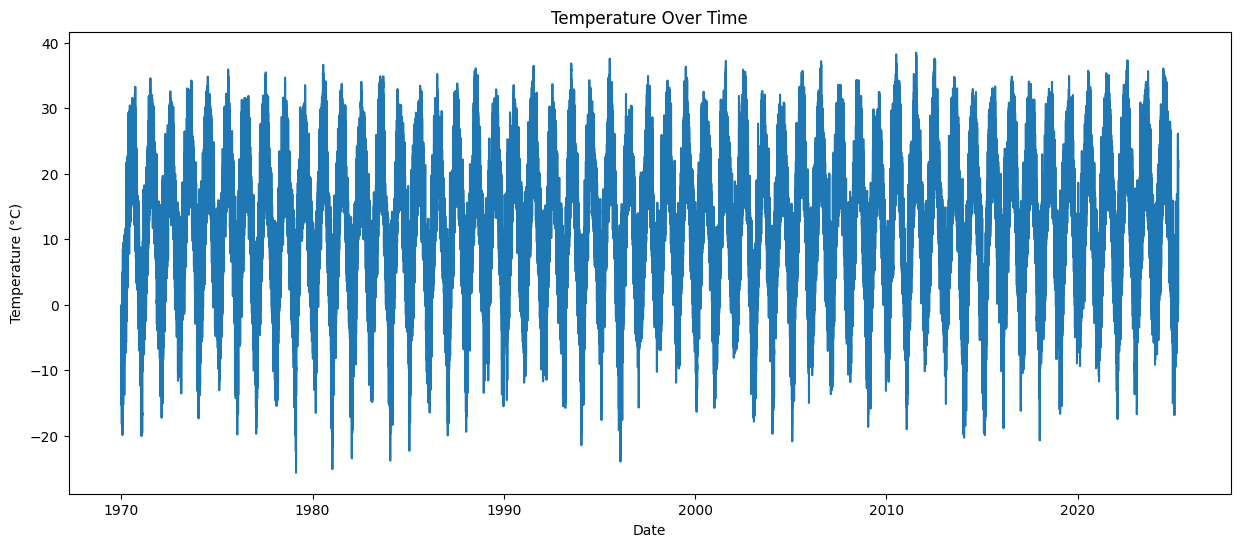

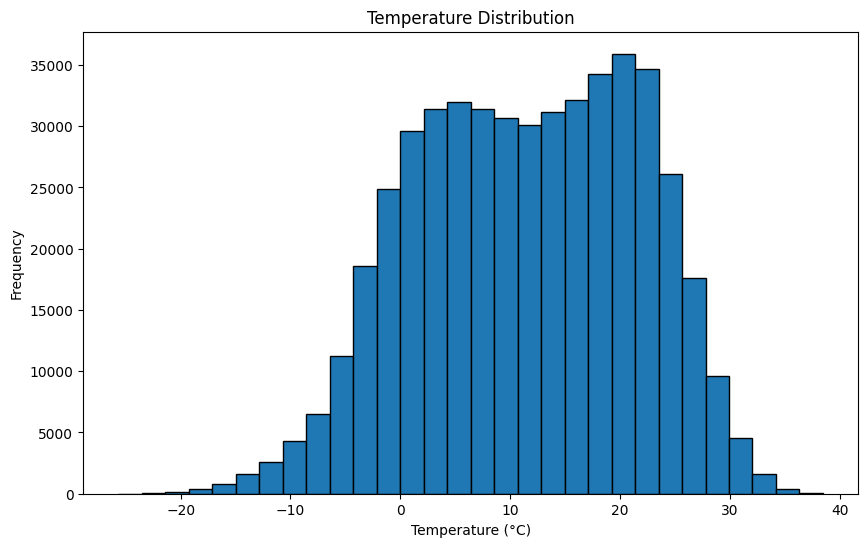

In [10]:
import matplotlib.pyplot as plt

nyc_hourly_dataframe.set_index("date", inplace=True)

# Plot the time series data
plt.figure(figsize=(15, 6))
plt.plot(nyc_hourly_dataframe["temperature_2m"])
plt.title("Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

# Plot a histogram of temperature values
plt.figure(figsize=(10, 6))
plt.hist(nyc_hourly_dataframe["temperature_2m"], bins=30, edgecolor="black")
plt.title("Temperature Distribution")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.show()

In [11]:
import matplotlib.pyplot as plt
from prophet import Prophet

print(nyc_hourly_dataframe.head())
print("Original DataFrame columns:", nyc_hourly_dataframe.columns)

# Rename columns to match the Prophet's requirements
nyc_df = nyc_hourly_dataframe.reset_index().rename(
    {"date": "ds", "temperature_2m": "y"}, axis=1
)
# credit: https://stackoverflow.com/a/73170360/13355500
nyc_df["ds"] = pd.to_datetime(nyc_df["ds"]).dt.tz_convert(
    None
)  # Ensure 'ds' is in datetime format

# Check the column names after renaming
print("DataFrame columns after renaming:", nyc_df.columns)
# Model fit
nyc_m = Prophet()
nyc_m.fit(nyc_df)

# Predict
future = nyc_m.make_future_dataframe(periods=365)
forecast = nyc_m.predict(future)

# Plot results
fig1 = nyc_m.plot(forecast)
fig2 = nyc_m.plot_components(forecast)
plt.show()
forecast

/Users/peterracinejr./workspace/WTAMU/CIDM6330/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


                           temperature_2m
date                                     
1970-01-01 00:00:00+00:00         -2.8165
1970-01-01 01:00:00+00:00         -3.6165
1970-01-01 02:00:00+00:00         -4.3665
1970-01-01 03:00:00+00:00         -4.9665
1970-01-01 04:00:00+00:00         -5.6165
Original DataFrame columns: Index(['temperature_2m'], dtype='object')
DataFrame columns after renaming: Index(['ds', 'y'], dtype='object')


16:49:28 - cmdstanpy - INFO - Chain [1] start processing
16:51:03 - cmdstanpy - INFO - Chain [1] done processing


KeyboardInterrupt: 

In [14]:
from prophet.serialize import model_to_json, model_from_json

with open("./travelmanagement/apilist/utils/nyc_model.json", "w") as fout:
    fout.write(model_to_json(nyc_m))

with open("./travelmanagement/apilist/utils/nyc_model.json", "r") as fin:
    nyc_m = model_from_json(fin.read())

In [15]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession(".cache", expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 34.0522,
    "longitude": -118.2437,
    "start_date": "1970-01-01",
    "end_date": "2025-04-03",
    "hourly": "temperature_2m",
    "wind_speed_unit": "kn",
    "precipitation_unit": "inch",
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {
    "date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left",
    )
}

hourly_data["temperature_2m"] = hourly_temperature_2m

la_hourly_dataframe = pd.DataFrame(data=hourly_data)
la_hourly_dataframe.to_csv("./travelmanagement/apilist/utils/la_weather_data.csv")
print(la_hourly_dataframe)

Coordinates 34.05975341796875°N -118.23750305175781°E
Elevation 91.0 m asl
Timezone NoneNone
Timezone difference to GMT+0 0 s
                            date  temperature_2m
0      1970-01-01 00:00:00+00:00       17.351000
1      1970-01-01 01:00:00+00:00       14.901000
2      1970-01-01 02:00:00+00:00       13.451000
3      1970-01-01 03:00:00+00:00       12.651000
4      1970-01-01 04:00:00+00:00       10.651000
...                          ...             ...
484363 2025-04-03 19:00:00+00:00       17.677000
484364 2025-04-03 20:00:00+00:00       19.427000
484365 2025-04-03 21:00:00+00:00       20.876999
484366 2025-04-03 22:00:00+00:00       19.526999
484367 2025-04-03 23:00:00+00:00       17.077000

[484368 rows x 2 columns]


In [16]:
null_counts = la_hourly_dataframe.isnull().sum()
print(null_counts)

date              0
temperature_2m    0
dtype: int64


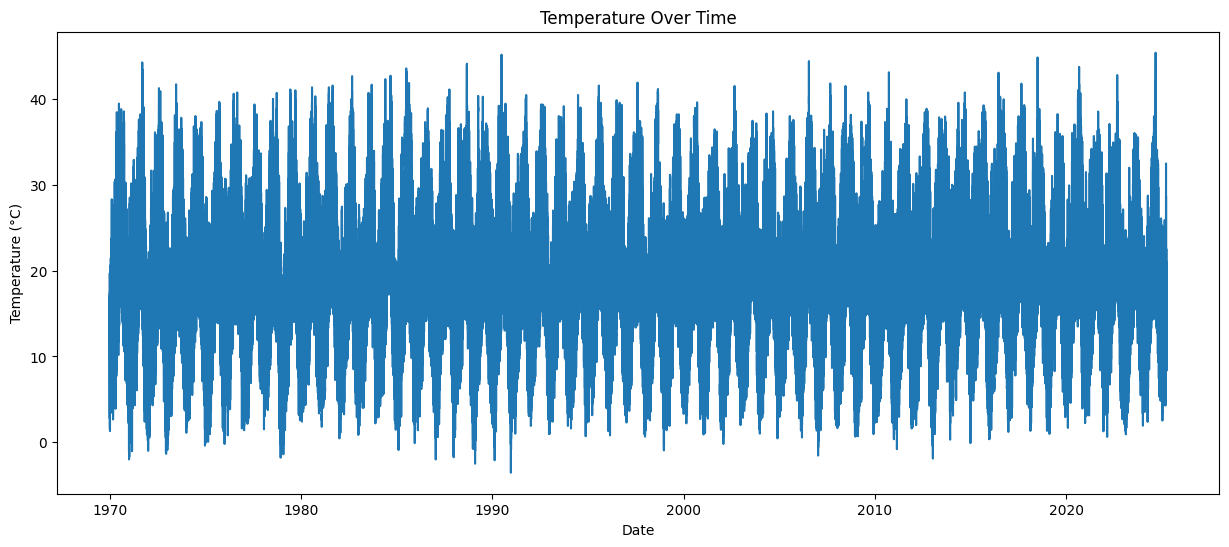

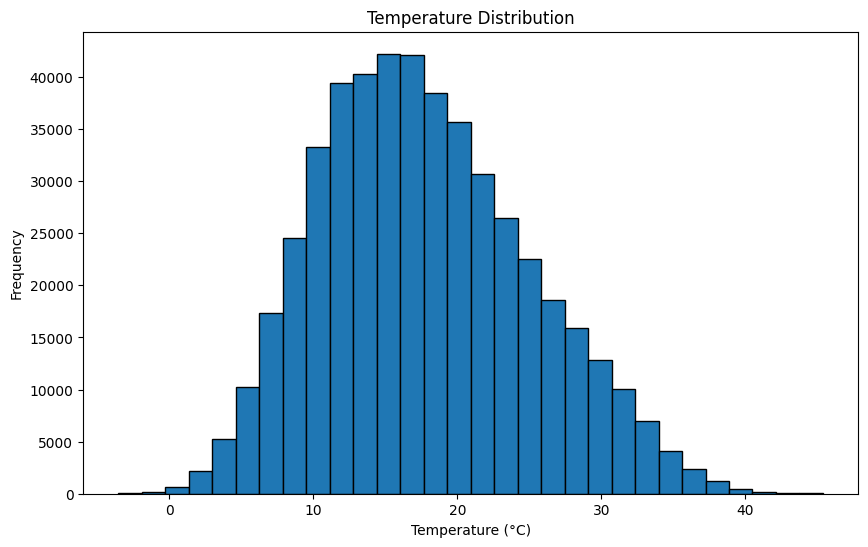

In [17]:
import matplotlib.pyplot as plt

la_hourly_dataframe.set_index("date", inplace=True)

# Plot the time series data
plt.figure(figsize=(15, 6))
plt.plot(la_hourly_dataframe["temperature_2m"])
plt.title("Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

# Plot a histogram of temperature values
plt.figure(figsize=(10, 6))
plt.hist(la_hourly_dataframe["temperature_2m"], bins=30, edgecolor="black")
plt.title("Temperature Distribution")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.show()

In [18]:
import matplotlib.pyplot as plt
from prophet import Prophet

print(la_hourly_dataframe.head())
print("Original DataFrame columns:", la_hourly_dataframe.columns)

# Rename columns to match the Prophet's requirements
la_df = la_hourly_dataframe.reset_index().rename(
    {"date": "ds", "temperature_2m": "y"}, axis=1
)
# credit: https://stackoverflow.com/a/73170360/13355500
la_df["ds"] = pd.to_datetime(la_df["ds"]).dt.tz_convert(
    None
)  # Ensure 'ds' is in datetime format

# Check the column names after renaming
print("DataFrame columns after renaming:", la_df.columns)
# Model fit
la_m = Prophet()
la_m.fit(la_df)

# Predict
future = la_m.make_future_dataframe(periods=365)
forecast = la_m.predict(future)

# Plot results
fig1 = la_m.plot(forecast)
fig2 = la_m.plot_components(forecast)
plt.show()
forecast

                           temperature_2m
date                                     
1970-01-01 00:00:00+00:00          17.351
1970-01-01 01:00:00+00:00          14.901
1970-01-01 02:00:00+00:00          13.451
1970-01-01 03:00:00+00:00          12.651
1970-01-01 04:00:00+00:00          10.651
Original DataFrame columns: Index(['temperature_2m'], dtype='object')
DataFrame columns after renaming: Index(['ds', 'y'], dtype='object')


16:58:52 - cmdstanpy - INFO - Chain [1] start processing
Python(97676) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
17:00:42 - cmdstanpy - INFO - Chain [1] done processing


KeyboardInterrupt: 

In [19]:
from prophet.serialize import model_to_json, model_from_json

with open("./travelmanagement/apilist/utils/la_model.json", "w") as fout:
    fout.write(model_to_json(la_m))

with open("./travelmanagement/apilist/utils/la_model.json", "r") as fin:
    la_m = model_from_json(fin.read())